## Read in and setup data

We have the option of reading in and setting up data from two different sources:

* Yelp! Restaurant Reviews
* Amazon Magazine Reviews

### Yelp! Restaurant Reviews

Sometimes it's easiest to test everything out with a small amount of data. The tab delimited [Restaurant Reviews Dataset](http://course.ccs.neu.edu/cs6220/fall2023/homework-5/Restaurant_Reviews.tsv) is a common dataset that is used for natural language tasks that predict the sentiment of a given review.

I've provided a helper script (called [cs6220hw5.py](http://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py)) that splits the data, standardizes the characters, and weeds out stop words, to parse and clean the text up, which should only be run once.

### Amazon Magazine Reviews

[This is the data for the homework](http://jmcauley.ucsd.edu/data/amazon/index_2014.html), which was released in 2014 and is slightly larger and may take some time to setup. We're only using the Magazine Subscriptions.

### Reference
* Jianmo Ni, Jiacheng Li, Julian McAuley, "*Justifying Recommendations using Distantly-Labeled Reviews and
Fine-Grained Aspects*", In Proceedings of **Empirical Methods in Natural Language Processing**, 2019

In [1]:
#@title Setup the Data (RUN ME)

# Which dataset to download?
dataset = 'magazines' # @param ["restaurant", "magazines"]

# Start with a clean slate
!rm -rf *
!wget -nc http://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py

# Import everything, including homework code
import numpy as np                                              # numpy array
import pandas as pd                                             # data science
import matplotlib.pyplot as plt                                 # matplotlib
import seaborn as sns                                           # plot style
from sklearn.metrics import confusion_matrix                    # confusion matrix
from sklearn.feature_extraction.text import CountVectorizer     # bag of words
from sklearn.model_selection import train_test_split            # train/test split
from sklearn.preprocessing import MinMaxScaler                  # scale data with min/max
from tqdm import tqdm_notebook as tqdm                          # download data utility
import json                                                     # amazon data in json
from IPython.display import clear_output
import cs6220hw5                                                # import cs6220

if dataset == 'restaurant':
  !wget -nc http://course.ccs.neu.edu/cs6220/fall2023/homework-5/Restaurant_Reviews.tsv

  # Read the CSV data
  data = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

else:
  # Download from https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/
  !wget -nc https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Magazine_Subscriptions.json.gz
  !gunzip Magazine_Subscriptions.json.gz

  # Load data in
  reviews = []
  with open('Magazine_Subscriptions.json', 'r') as f:
      for l in tqdm(f):
          r = json.loads(l)
          reviews.append(r)

  # Format the data into Pandas DataFrame
  data = pd.DataFrame.from_records(reviews)[['reviewText', 'overall']]
  print("Initial data size: ", data.size)
  data = data[ data['overall'] != 3.0]
  data = data.rename(columns={"reviewText": "Review"})
  data['Liked'] = 0
  data.loc[data['overall'] > 3, 'Liked'] = 1
  data = data.dropna()

clear_output()
print("Data matrix has shape: ", data.shape)
data.head(10)

Data matrix has shape:  (82687, 3)


,Review,overall,Liked
0,"for computer enthusiast, MaxPC is a welcome si...",5.0,1
1,Thank god this is not a Ziff Davis publication...,5.0,1
3,This beautiful magazine is in itself a work of...,5.0,1
4,A great read every issue.,5.0,1
6,I've read Maximum PC (MPC) for many years. The...,5.0,1
7,We ordered this magazine for our grandson (the...,5.0,1
8,I have subscribed to the nook version for a fe...,4.0,1
9,"I'm old, and so is my computer. Any advice th...",4.0,1
10,"At one time, this was my least favorite comput...",5.0,1
11,I didn't receive a full year. I only receive ...,2.0,0


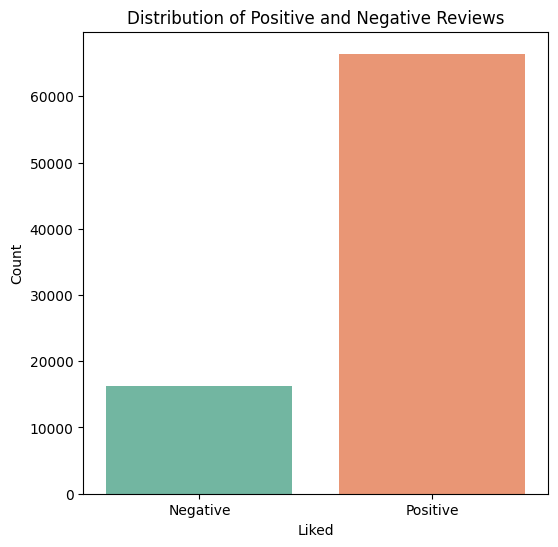

In [2]:
#@title Create a histogram of positive vs negative labels (YOUR CODE HERE)
plt.figure(figsize=(6, 6))
sns.countplot(x='Liked', data=data, palette='Set2')
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Liked')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

## Preprocess data

Here, you will:

* **Rebalance** the *training data* (leave the test dataset the same).
* **Clean up** the data: remove stopwords, punctuation, verb tense, etc.
* **Assign words** to a "bag of words" where each input feature is a histogram (count) of which words occur in the review.

To clean up the data, I have provided a function in [`cs6220hw5.py`](https://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py) called `clean_text`. Go ahead and take a look at what it does and explain. This takes a long time to run. What takes the most amount of time? Why?

You will notice in the "bag of words" featurization there are a lot of design decisions.

In [11]:
#@title Create splits & rebalance **training** data (YOUR CODE HERE)

test_size = 0.1 #@param
# X = data['Review'] #@param
# y = data['Liked'] #@param

'''
You will need to

1. Split the training and test dataset to be 90 / 10%
2. Rebalance the training dataset so that it's 50/50
   positive / negative
'''
# Split the training and test dataset to be 90 / 10%
training_data, testing_data = train_test_split(data, test_size=test_size, random_state=42)

# Rebalance the training dataset
positive_reviews = training_data[training_data['Liked'] == 1]
negative_reviews = training_data[training_data['Liked'] == 0]

# Sample an equal number of positive and negative reviews
sample_size = min(len(positive_reviews), len(negative_reviews))
balanced_training_data = pd.concat([positive_reviews.sample(sample_size), negative_reviews.sample(sample_size)])
balanced_training_data = balanced_training_data.sample(frac=1, random_state=42)
training_data = balanced_training_data

# Print the shapes of the training and testing data
print("Training Data Shape:", training_data.shape)
print("Testing Data Shape:", testing_data.shape)


Training Data Shape: (29368, 3)
Testing Data Shape: (8269, 3)


In [18]:
#@title Clean text with `cs6220hw5.py`. (RUN ME & get some coffee; it takes a while.)

# The following code takes training data in the same format:
#    Review	| Stars |	Liked
training_corpus, testing_corpus = cs6220hw5.clean_text(training_data, testing_data)
print("training_corpus")
print(training_corpus)
print("testing_corpus")
print(testing_corpus)

training_corpus
43643                               compat microsoft phone
13857    mix articl alway balanc articl short other lon...
40913    matter whether scientif american adopt polit l...
69806                                  alway like read mag
74325    psych see address back magazin would go kindl ...
                               ...                        
9010     receiv notic write review month sinc subscript...
32960    anoth magazin wife whatev make happi love read...
19760    great product fast deliveri servic followup thank
13363    mechan allow sign consumerreport org subscrib ...
51942    print subscript peopl occasion read kindl fire...
Name: Review, Length: 29368, dtype: object
testing_corpus
80651    especi christian worldview write sound fact we...
4870     enjoy look magazin prefer countri live casual ...
88793                                      favorit magazin
86035    look forward issu give neat stori southern art...
60132    bought coupon meet expect bad ma

In [19]:
#@title Featurize into Bag of Words (Example Code)

# creating the count vectorizer model with max_features
vocab_size = 200                #@param
test_size = 0.1                 #@param
minmax_scale = True             #@param

cv = CountVectorizer(max_features = vocab_size)
x_train = cv.fit_transform(training_corpus).toarray()
y_train = np.array(training_data['Liked'])

x_test = cv.fit_transform(testing_corpus).toarray()
y_test = np.array(testing_data['Liked'])

if minmax_scale:
  mm = MinMaxScaler()
  x_train = mm.fit_transform(x_train)
  x_test = mm.transform(x_test)

# Run all the algorithms

Play around with some thresholds. Because your evaluation dataset has the original distribution, play with that parameter. For each algorithm, print out:

* Accuracy
* Confusion Matrix
* Precision / Recall AUC

In [20]:
#@title Naive Bayes, Random Forest, Decision Tree Classifier, Logistic Regression (YOUR CODE HERE)

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, auc

# Create a list of classifiers
classifiers = [
    ('Naive Bayes', GaussianNB()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
]

# Train and evaluate each classifier
for name, clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    precision_recall_auc = auc(recall, precision)

    print(f"Classifier: {name}")
    print(f"Accuracy: {acc:.2f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision/Recall AUC: {precision_recall_auc:.2f}")

Classifier: Naive Bayes
Accuracy: 0.55
Confusion Matrix:
[[ 987  580]
 [3122 3580]]
Precision/Recall AUC: 0.89
Classifier: Random Forest
Accuracy: 0.41
Confusion Matrix:
[[1219  348]
 [4555 2147]]
Precision/Recall AUC: 0.87
Classifier: Decision Tree
Accuracy: 0.44
Confusion Matrix:
[[ 989  578]
 [4079 2623]]
Precision/Recall AUC: 0.85
Classifier: Logistic Regression
Accuracy: 0.34
Confusion Matrix:
[[1302  265]
 [5160 1542]]
Precision/Recall AUC: 0.85
